In [38]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xg 
import pickle
import sklearn
import random
import statsmodels.api as sm
random.seed(10)

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import f_regression, SelectKBest, mutual_info_regression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Functions

In [39]:
# IQR Function with quantiles (10, 90) 
def IQR(column_name, data):
    IQR = 0
    
    q1 = data[column_name].quantile(.10)
    q3 = data[column_name].quantile(.90)
    
    IQR= q3 - q1
    
    lower= q1 - 1.5 * IQR
    upper= q3 + 1.5 * IQR
    
    data.drop(data[((data[column_name] > upper) | (data[column_name] < lower))].index, inplace= True, axis=0)



## Reading Data

In [40]:
trash = pd.read_excel("data.xlsx", header=1)
trash

,Measured Depth,GR,NPHI,RHOB,RT,THOR,URAN,K,ki,eUi,KD%,eUD%,DRAD,RHP Spectro,RHP GR,Hydrocarbon Saturation,Unnamed: 16,Unnamed: 17
0,3945.2998,42.0540,0.2718,2.2235,1.1550,2.2815,1.7092,1.25,1.090668,1.446805,0.127465,0.153519,0.026054,0.588388,0.651813,0.664217,NaN,Notes for programmer
1,3945.7998,44.6129,0.3469,2.1352,1.2407,2.4650,1.7938,1.30,1.178390,1.563171,0.093546,0.128570,0.035024,0.595964,0.692244,0.718131,NaN,استنتاج ألجرزم يتنبأ بقيمة عمود ال DRAD اللى ب...
2,3946.2998,44.9639,0.3767,2.2745,1.3228,2.5241,1.8231,1.33,1.206643,1.600649,0.092750,0.122018,0.029268,0.647004,0.697790,0.727256,NaN,NaN
3,3946.7998,43.3759,0.3300,2.4704,1.2631,2.4110,1.7866,1.33,1.152576,1.528927,0.133402,0.144225,0.010824,0.686993,0.672699,0.681435,NaN,NaN
4,3947.2998,43.5552,0.2448,2.5271,1.3076,2.3140,1.7532,1.37,1.106205,1.467415,0.192551,0.163008,-0.029543,0.691968,0.675532,0.639279,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14469,6241.2002,17.7210,0.0899,2.6502,3.5923,1.7863,2.5165,0.65,0.387145,1.181811,0.404393,0.530375,0.125983,0.816050,0.267352,0.738636,NaN,NaN
14470,6241.7002,20.4997,0.1056,2.6497,1.6030,1.9463,2.4755,0.79,0.421822,1.287666,0.466049,0.479836,0.013787,0.829316,0.311255,0.582267,NaN,NaN
14471,6242.2002,33.2205,0.1318,2.6114,1.0417,3.9613,2.5625,1.06,0.858533,2.620784,0.190063,-0.022745,-0.212808,0.998201,0.512244,0.521975,NaN,NaN
14472,6242.7002,43.4114,0.1892,2.4836,0.9137,6.5010,2.6685,1.10,1.408962,4.301042,-0.280875,-0.611783,-0.330908,1.139344,0.673260,0.570531,NaN,NaN


In [41]:
trash.isna().sum()

Measured Depth                0
GR                            0
NPHI                          0
RHOB                          0
RT                            0
THOR                          0
URAN                          0
K                             0
ki                            0
eUi                           0
KD%                           0
eUD%                          0
DRAD                          0
RHP Spectro                   0
RHP GR                        0
Hydrocarbon Saturation       96
Unnamed: 16               14474
Unnamed: 17               14472
dtype: int64

In [42]:
# Remove last 3 columns
features = trash.iloc[:,:12]
features

,Measured Depth,GR,NPHI,RHOB,RT,THOR,URAN,K,ki,eUi,KD%,eUD%
0,3945.2998,42.0540,0.2718,2.2235,1.1550,2.2815,1.7092,1.25,1.090668,1.446805,0.127465,0.153519
1,3945.7998,44.6129,0.3469,2.1352,1.2407,2.4650,1.7938,1.30,1.178390,1.563171,0.093546,0.128570
2,3946.2998,44.9639,0.3767,2.2745,1.3228,2.5241,1.8231,1.33,1.206643,1.600649,0.092750,0.122018
3,3946.7998,43.3759,0.3300,2.4704,1.2631,2.4110,1.7866,1.33,1.152576,1.528927,0.133402,0.144225
4,3947.2998,43.5552,0.2448,2.5271,1.3076,2.3140,1.7532,1.37,1.106205,1.467415,0.192551,0.163008
...,...,...,...,...,...,...,...,...,...,...,...,...
14469,6241.2002,17.7210,0.0899,2.6502,3.5923,1.7863,2.5165,0.65,0.387145,1.181811,0.404393,0.530375
14470,6241.7002,20.4997,0.1056,2.6497,1.6030,1.9463,2.4755,0.79,0.421822,1.287666,0.466049,0.479836
14471,6242.2002,33.2205,0.1318,2.6114,1.0417,3.9613,2.5625,1.06,0.858533,2.620784,0.190063,-0.022745
14472,6242.7002,43.4114,0.1892,2.4836,0.9137,6.5010,2.6685,1.10,1.408962,4.301042,-0.280875,-0.611783


In [43]:
# Determine target column
target = trash.iloc[:,12]
target

0        0.026054
1        0.035024
2        0.029268
3        0.010824
4       -0.029543
           ...   
14469    0.125983
14470    0.013787
14471   -0.212808
14472   -0.330908
14473   -0.315873
Name: DRAD, Length: 14474, dtype: float64

In [44]:
df = pd.concat([features, target], axis=1)
df

,Measured Depth,GR,NPHI,RHOB,RT,THOR,URAN,K,ki,eUi,KD%,eUD%,DRAD
0,3945.2998,42.0540,0.2718,2.2235,1.1550,2.2815,1.7092,1.25,1.090668,1.446805,0.127465,0.153519,0.026054
1,3945.7998,44.6129,0.3469,2.1352,1.2407,2.4650,1.7938,1.30,1.178390,1.563171,0.093546,0.128570,0.035024
2,3946.2998,44.9639,0.3767,2.2745,1.3228,2.5241,1.8231,1.33,1.206643,1.600649,0.092750,0.122018,0.029268
3,3946.7998,43.3759,0.3300,2.4704,1.2631,2.4110,1.7866,1.33,1.152576,1.528927,0.133402,0.144225,0.010824
4,3947.2998,43.5552,0.2448,2.5271,1.3076,2.3140,1.7532,1.37,1.106205,1.467415,0.192551,0.163008,-0.029543
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14469,6241.2002,17.7210,0.0899,2.6502,3.5923,1.7863,2.5165,0.65,0.387145,1.181811,0.404393,0.530375,0.125983
14470,6241.7002,20.4997,0.1056,2.6497,1.6030,1.9463,2.4755,0.79,0.421822,1.287666,0.466049,0.479836,0.013787
14471,6242.2002,33.2205,0.1318,2.6114,1.0417,3.9613,2.5625,1.06,0.858533,2.620784,0.190063,-0.022745,-0.212808
14472,6242.7002,43.4114,0.1892,2.4836,0.9137,6.5010,2.6685,1.10,1.408962,4.301042,-0.280875,-0.611783,-0.330908


## Data PreProcessing

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14474 entries, 0 to 14473
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Measured Depth  14474 non-null  float64
 1   GR              14474 non-null  float64
 2   NPHI            14474 non-null  float64
 3   RHOB            14474 non-null  float64
 4   RT              14474 non-null  float64
 5   THOR            14474 non-null  float64
 6   URAN            14474 non-null  float64
 7   K               14474 non-null  float64
 8   ki              14474 non-null  float64
 9   eUi             14474 non-null  float64
 10  KD%             14474 non-null  float64
 11  eUD%            14474 non-null  float64
 12  DRAD            14474 non-null  float64
dtypes: float64(13)
memory usage: 1.4 MB


In [46]:
df.describe()

,Measured Depth,GR,NPHI,RHOB,RT,THOR,URAN,K,ki,eUi,KD%,eUD%,DRAD
count,14474.000000,14474.000000,14474.000000,14474.000000,14474.000000,14474.000000,14474.000000,14474.000000,14474.000000,14474.000000,14474.000000,14474.000000,14474.000000
mean,5086.809124,31.256834,0.240806,2.413248,4.629312,2.596746,1.295995,0.809480,0.808696,1.293417,0.092133,-0.105804,-0.197936
std,703.297000,19.952150,0.119716,0.182558,67.694806,2.291409,0.888931,0.392421,0.773545,1.349912,0.551634,0.820639,0.737787
min,3736.499000,0.762000,-0.019000,1.283400,0.132100,0.010000,0.027900,0.040000,0.002579,0.006341,-8.556704,-7.752296,-7.312167
25%,4484.225100,16.987650,0.151200,2.301725,0.602425,0.860000,0.580000,0.560000,0.293741,0.452453,-0.175143,-0.450021,-0.439883
50%,5087.250000,27.009850,0.219700,2.438100,1.151700,1.897300,1.079700,0.760000,0.561327,0.739200,0.169170,0.064139,-0.054323
75%,5690.274900,40.524650,0.302275,2.542300,2.013950,3.468350,1.835125,1.010000,1.032664,1.577307,0.475100,0.460595,0.198788
max,6421.799800,122.380000,0.683800,3.025900,1976.300000,15.336900,8.547700,3.000000,5.677403,10.146846,0.994808,0.994276,3.492033


In [47]:
df.duplicated().sum()

0

#### -Apply Domain Knowledge
###### --DRAD Values should be from -3 to 3

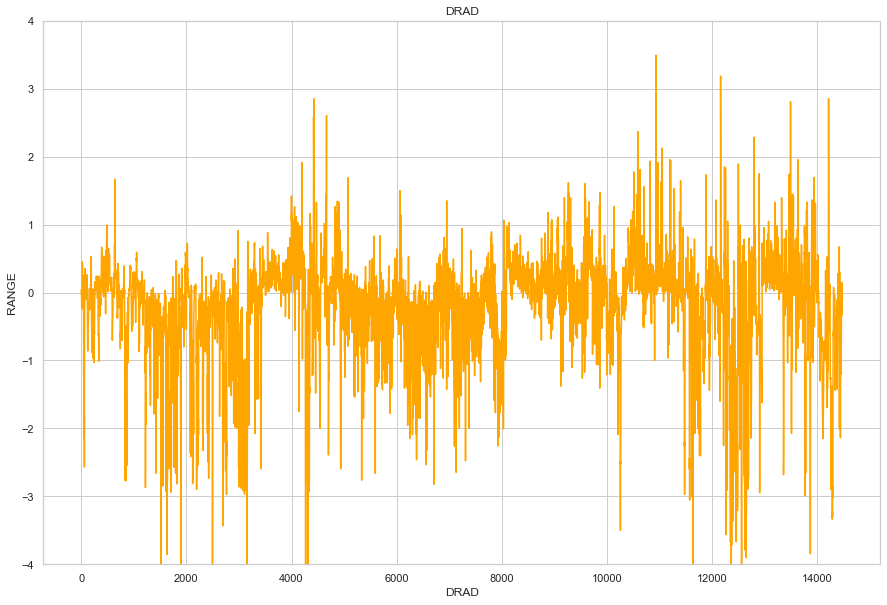

In [48]:
# DRAD Values should be from -3 to 3 ==> Domain Knowledge

sns.set(style="whitegrid")
 
plt.figure(figsize=(15, 10))
sns.lineplot(data=df, x=df["DRAD"].index, y=df["DRAD"], color='orange')
 
# Adding labels and title
plt.ylim(-4, 4)

plt.xlabel('DRAD')
plt.ylabel('RANGE')
plt.title('DRAD')
 
plt.show()

In [49]:
#Domain Knowledge 
df.drop(df[(df["DRAD"] > 3) | (df["DRAD"] < -3)].index, axis=0, inplace= True)

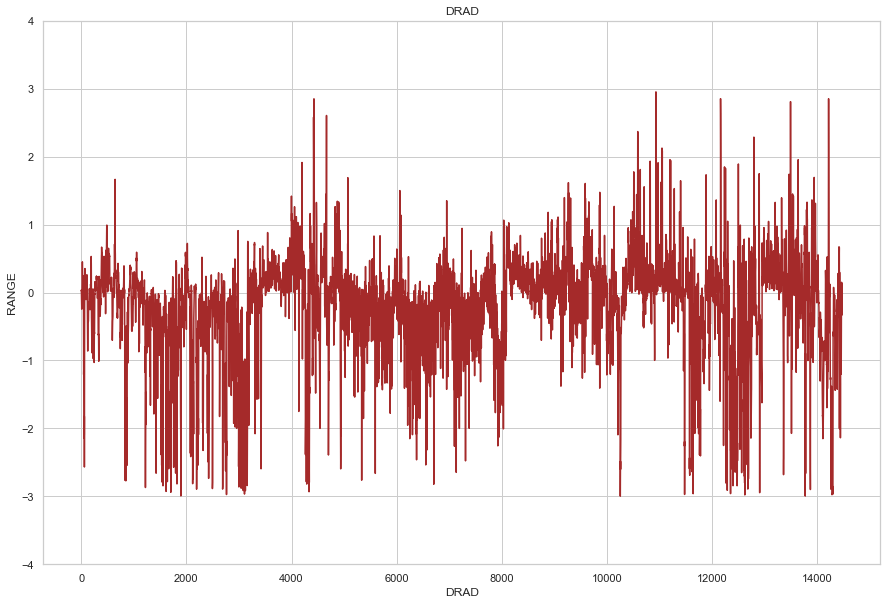

In [50]:
sns.set(style="whitegrid") 
 
plt.figure(figsize=(15, 10)) 
sns.lineplot(data=df, x=df["DRAD"].index, y=df["DRAD"], color='brown')
 
# Adding labels and title
plt.ylim(-4, 4)

plt.xlabel('DRAD')
plt.ylabel('RANGE')
plt.title('DRAD')
 
plt.show()

#### -Dealing with Outliers

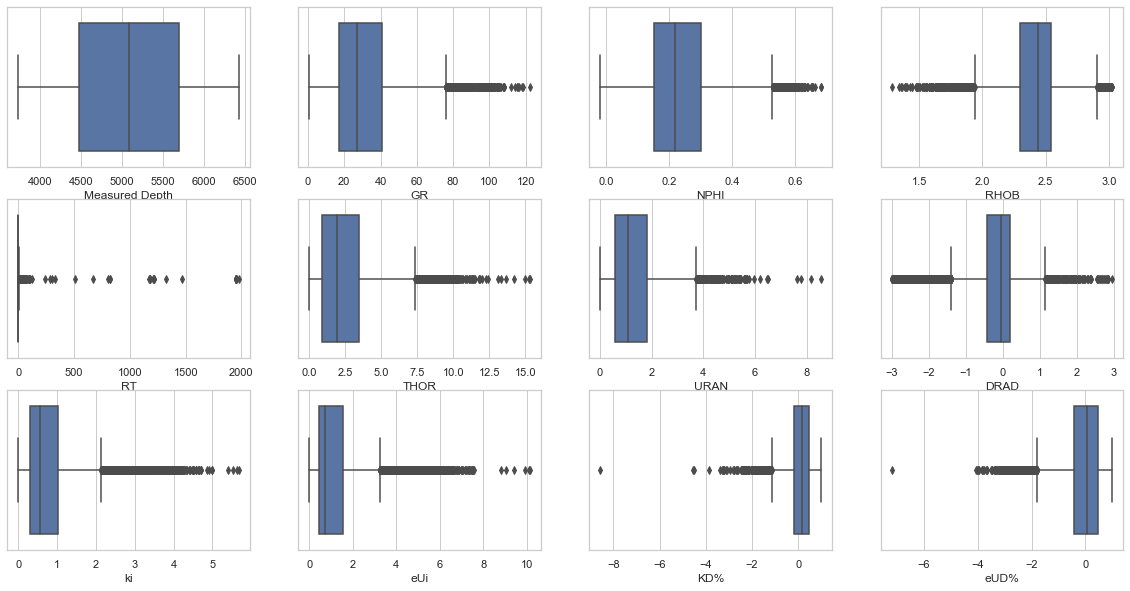

In [51]:
# plt.figure(figsize=(10,10))
fig, ax = plt.subplots(3, 4, figsize= (20, 10))

sns.boxplot(x= df["Measured Depth"], data= df, ax= ax[0, 0])
sns.boxplot(x= df["GR"],             data= df, ax= ax[0, 1])
sns.boxplot(x= df["NPHI"],           data= df, ax= ax[0, 2])
sns.boxplot(x= df["RHOB"],           data= df, ax= ax[0, 3])
sns.boxplot(x= df["RT"],             data= df, ax= ax[1, 0])
sns.boxplot(x= df["THOR"],           data= df, ax= ax[1, 1])
sns.boxplot(x= df["URAN"],           data= df, ax= ax[1, 2])
sns.boxplot(x= df["DRAD"],           data= df, ax= ax[1, 3])
sns.boxplot(x= df["ki"],             data= df, ax= ax[2, 0])
sns.boxplot(x= df["eUi"],           data= df, ax= ax[2, 1])
sns.boxplot(x= df["KD%"],           data= df, ax= ax[2, 2])
sns.boxplot(x= df["eUD%"],           data= df, ax= ax[2, 3])

plt.show()

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14406 entries, 0 to 14473
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Measured Depth  14406 non-null  float64
 1   GR              14406 non-null  float64
 2   NPHI            14406 non-null  float64
 3   RHOB            14406 non-null  float64
 4   RT              14406 non-null  float64
 5   THOR            14406 non-null  float64
 6   URAN            14406 non-null  float64
 7   K               14406 non-null  float64
 8   ki              14406 non-null  float64
 9   eUi             14406 non-null  float64
 10  KD%             14406 non-null  float64
 11  eUD%            14406 non-null  float64
 12  DRAD            14406 non-null  float64
dtypes: float64(13)
memory usage: 2.0 MB


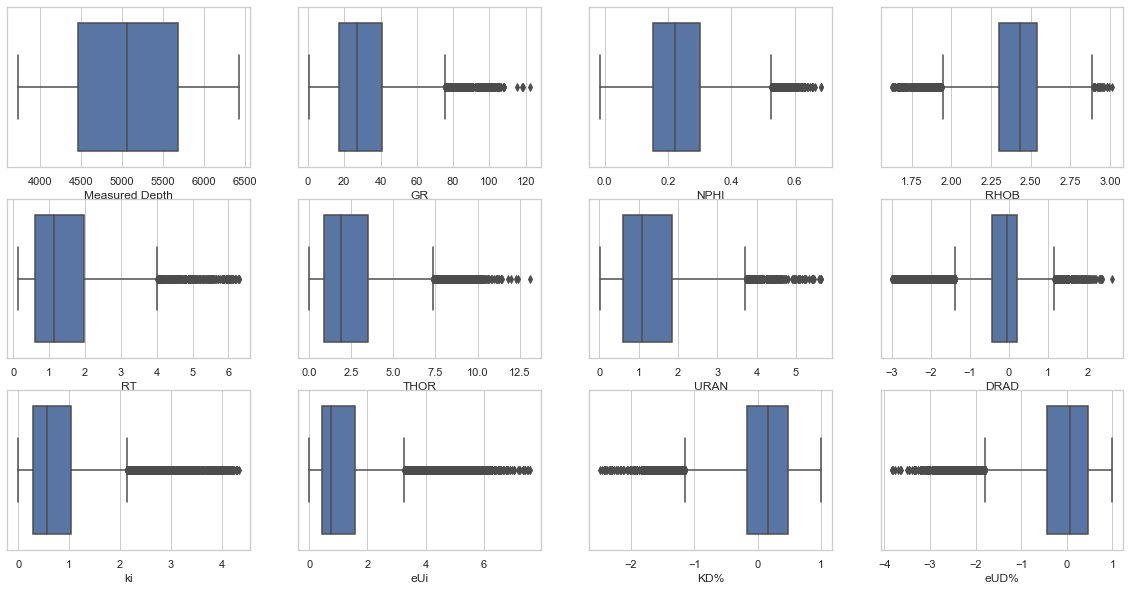

In [53]:
for num in range(2):
    for col in df.columns.to_list():
        IQR(col, df)
        
    df.reset_index(inplace=True, drop= True)
    

    
fig, ax = plt.subplots(3, 4, figsize= (20, 10))

sns.boxplot(x= df["Measured Depth"], data= df, ax= ax[0, 0])
sns.boxplot(x= df["GR"],             data= df, ax= ax[0, 1])
sns.boxplot(x= df["NPHI"],           data= df, ax= ax[0, 2])
sns.boxplot(x= df["RHOB"],           data= df, ax= ax[0, 3])
sns.boxplot(x= df["RT"],             data= df, ax= ax[1, 0])
sns.boxplot(x= df["THOR"],           data= df, ax= ax[1, 1])
sns.boxplot(x= df["URAN"],           data= df, ax= ax[1, 2])
sns.boxplot(x= df["DRAD"],           data= df, ax= ax[1, 3])
sns.boxplot(x= df["ki"],             data= df, ax= ax[2, 0])
sns.boxplot(x= df["eUi"],           data= df, ax= ax[2, 1])
sns.boxplot(x= df["KD%"],           data= df, ax= ax[2, 2])
sns.boxplot(x= df["eUD%"],           data= df, ax= ax[2, 3])

plt.show()

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14071 entries, 0 to 14070
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Measured Depth  14071 non-null  float64
 1   GR              14071 non-null  float64
 2   NPHI            14071 non-null  float64
 3   RHOB            14071 non-null  float64
 4   RT              14071 non-null  float64
 5   THOR            14071 non-null  float64
 6   URAN            14071 non-null  float64
 7   K               14071 non-null  float64
 8   ki              14071 non-null  float64
 9   eUi             14071 non-null  float64
 10  KD%             14071 non-null  float64
 11  eUD%            14071 non-null  float64
 12  DRAD            14071 non-null  float64
dtypes: float64(13)
memory usage: 1.4 MB


In [57]:
target.iloc[7000]

-0.17765022852137588

## EDA

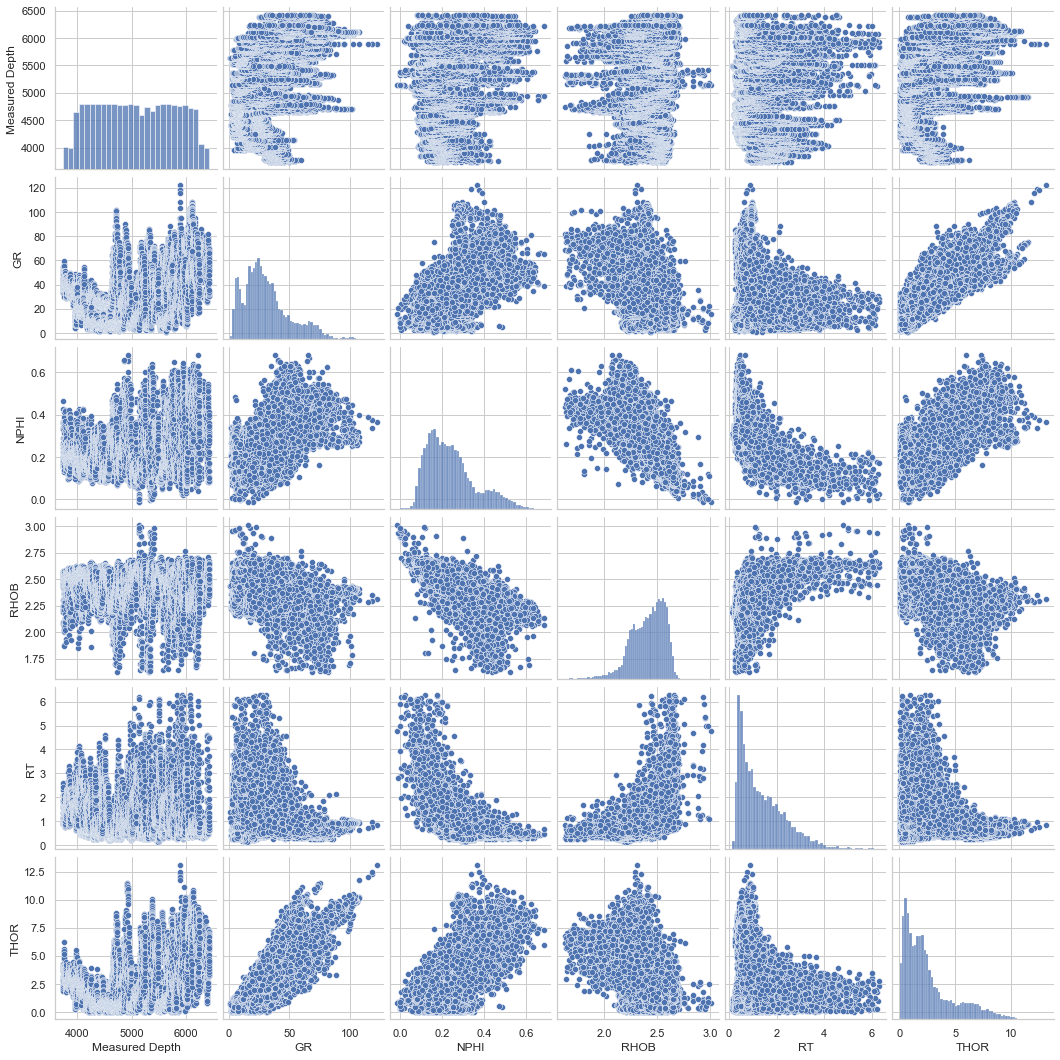

In [18]:
sns.pairplot(df.iloc[:, :6])

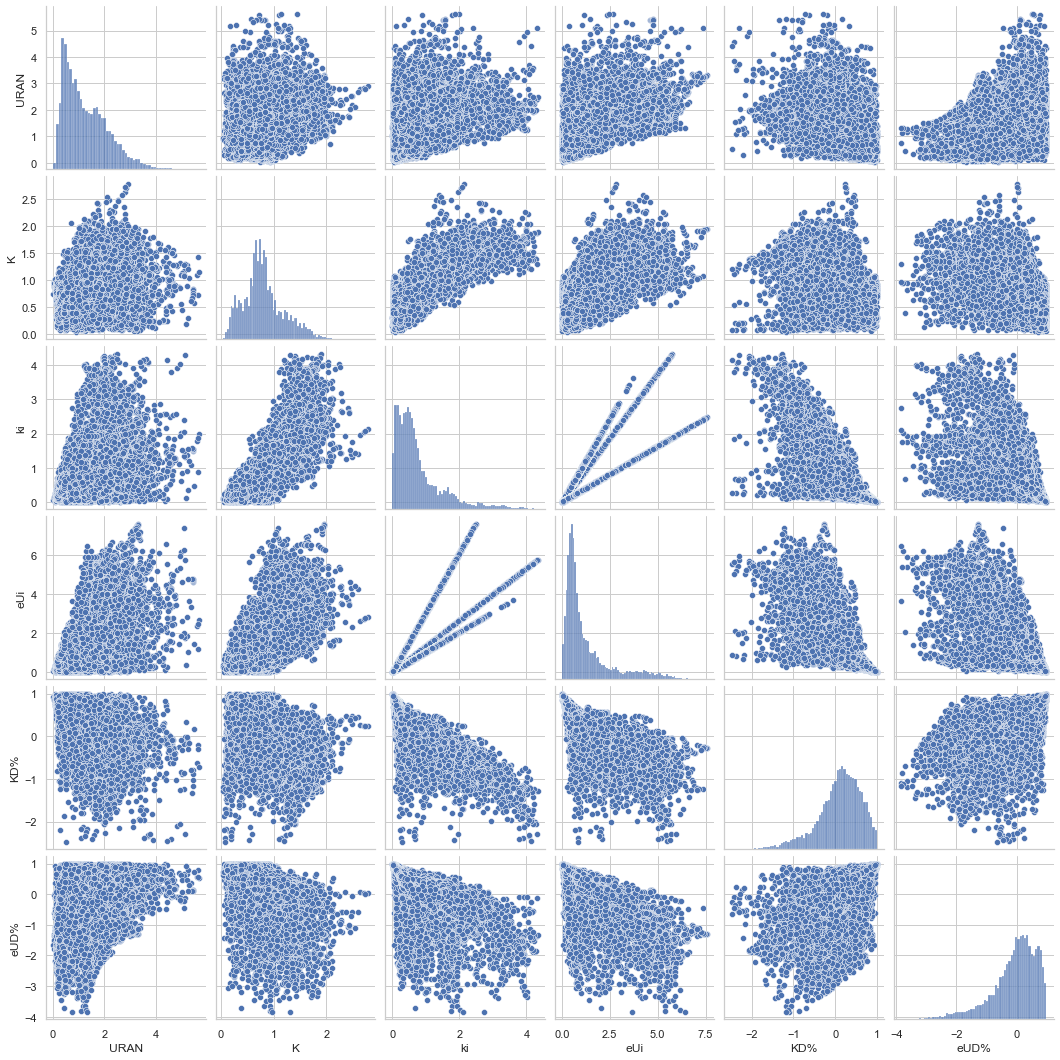

In [19]:
sns.pairplot(df.iloc[:, 6:-1])

<AxesSubplot:>

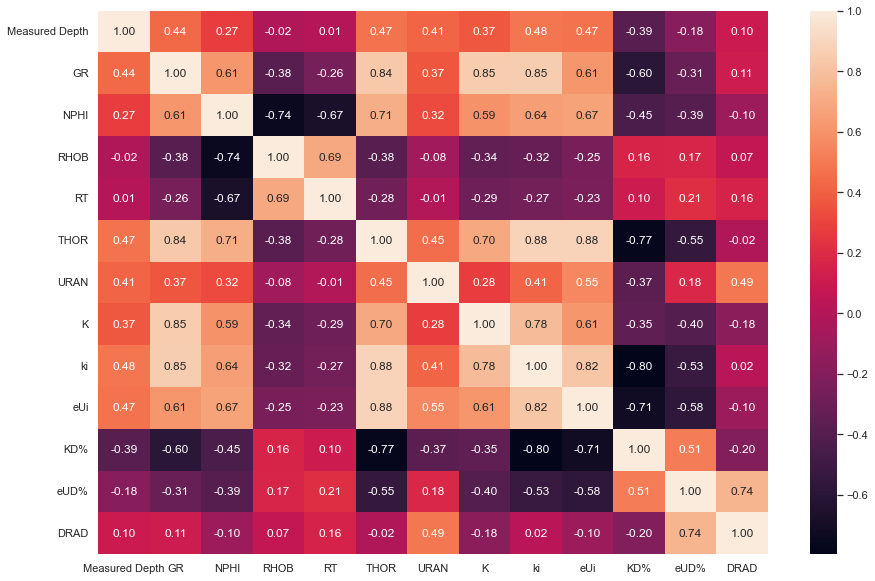

In [20]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, fmt=".2f")

## Models

## Polynomial Regression

In [21]:
features = df.iloc[:,:-1]
# features = features.drop(columns=["GR"], axis= 1) # We should remove GR column but we can not because of the Domain
target = df.iloc[:,-1]

In [22]:
x_train, X_test, y_train, Y_test = train_test_split(features, target, test_size=.2, random_state=42, shuffle=True)

In [23]:
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
X_test = ss.transform(X_test)

In [24]:
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(x_train)
X_poly_test = poly.transform(X_test)


model = LinearRegression()
model.fit(X_poly_train, np.ravel(y_train))

LinearRegression()

In [25]:
ploy_pred= model.predict(X_poly_test)
mean_squared_error(Y_test, ploy_pred)

9.852685583985916e-30

In [26]:
x_train = pd.DataFrame(x_train, columns=features.columns)

vif_data = pd.DataFrame()
vif_data["Feature"] = x_train.columns
vif_data["VIF"] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]

print(vif_data)

           Feature        VIF
0   Measured Depth   1.469210
1               GR  19.627226
2             NPHI   6.418283
3             RHOB   3.281817
4               RT   2.463640
5             THOR  21.585427
6             URAN   3.474827
7                K  10.623505
8               ki  14.761943
9              eUi  18.218552
10             KD%   7.196253
11            eUD%   3.982875


'''
We should remove GR column but we can not because of the Constraints we got from the domain Knowledge
'''

## Save & Load

In [27]:
with open('Poly_model.pkl', 'wb') as file:
    pickle.dump(model, file)
# with open('ols_model.pkl', 'rb') as file:
#     loaded_results = pickle.load(file)

## Linear Regrission

In [28]:
features = df.iloc[:,:-1]
target = df.iloc[:,-1]

In [29]:
x_train, X_test, y_train, Y_test = train_test_split(features, target, test_size=.2, random_state=42, shuffle=True)

In [30]:
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
X_test = ss.transform(X_test)

In [31]:
lr_model = LinearRegression()
lr_model.fit(x_train, np.ravel(y_train))

LinearRegression()

In [32]:
lr_pred= lr_model.predict(X_test)

mse = mean_squared_error(y_true= Y_test, y_pred=lr_pred)
mse

7.4739844287886406e-31

In [36]:
results = pd.DataFrame({
    'Actual': Y_test,
    'Predicted': lr_pred
})
results

,Actual,Predicted
10673,0.534849,0.534849
7007,-0.904213,-0.904213
4096,1.086159,1.086159
6556,-0.282967,-0.282967
2848,0.450154,0.450154
...,...,...
9864,-0.992266,-0.992266
1272,-0.727649,-0.727649
8094,0.236379,0.236379
11013,0.019548,0.019548


In [37]:
features.columns

Index(['Measured Depth', 'GR', 'NPHI', 'RHOB', 'RT', 'THOR', 'URAN', 'K', 'ki',
       'eUi', 'KD%', 'eUD%'],
      dtype='object')

## Save Model

In [64]:
with open('LinearRegression.pkl', 'wb') as file:
    pickle.dump(lr_model, file)
# with open('linear_model.pkl', 'rb') as file:
#     loaded_results = pickle.load(file)

## Random Forest

In [65]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=100 ,  random_state=42)
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(X_test)



In [66]:
mse = mean_squared_error(Y_test, y_pred)
mse

0.0012044336617734034

In [67]:
rf_model.feature_importances_ * 1e4

array([5.25518146e+00, 7.40716751e+00, 3.30999928e+00, 3.60317312e+00,
       3.90828562e+00, 7.51825436e+00, 1.59328602e+03, 5.71807786e+01,
       2.15154683e+01, 4.38850807e+00, 2.05878663e+03, 6.23384054e+03])

## SVC

In [68]:
svc = SVR(kernel="linear")
svc.fit(x_train, y_train)

svc_pred = svc.predict(X_test)

mse = mean_squared_error(y_true= Y_test, y_pred=svc_pred)
mse

0.0028655666051876877